In [38]:
import pandas as pd
import numpy as np
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

In [13]:
df=pd.read_csv("MSFT.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061434,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063628,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064725,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063079,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061982,47894400


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9083 entries, 0 to 9082
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9083 non-null   object 
 1   Open       9083 non-null   float64
 2   High       9083 non-null   float64
 3   Low        9083 non-null   float64
 4   Close      9083 non-null   float64
 5   Adj Close  9083 non-null   float64
 6   Volume     9083 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 496.9+ KB


In [16]:
cat_df = df.select_dtypes(include=['object'])
num_df = df.select_dtypes(exclude=['object'])
print(cat_df)

            Date
0     1986-03-13
1     1986-03-14
2     1986-03-17
3     1986-03-18
4     1986-03-19
...          ...
9078  2022-03-18
9079  2022-03-21
9080  2022-03-22
9081  2022-03-23
9082  2022-03-24

[9083 rows x 1 columns]


In [17]:
def printColumnTypes(non_numeric_df, numeric_df):
    '''separates non-numeric and numeric columns'''
    print("Non-Numeric columns:")
    for col in non_numeric_df:
        print(f"{col}")
    print("")
    print("Numeric columns:")
    for col in numeric_df:
        print(f"{col}")
        
printColumnTypes(cat_df, num_df)

Non-Numeric columns:
Date

Numeric columns:
Open
High
Low
Close
Adj Close
Volume


In [18]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [20]:
def missing_cols(df):
    '''prints out columns with its amount of missing values'''
    total = 0
    for col in df.columns:
        missing_vals = df[col].isnull().sum()
        total += missing_vals
        if missing_vals != 0:
            print(f"{col} => {df[col].isnull().sum()}")
    
    if total == 0:
        print("no missing values left")
            
missing_cols(df)

no missing values left


In [21]:
df.duplicated().any()

False

In [35]:
df.shape

(9083, 7)

In [36]:
Y=df.iloc[:,5]
Y

0         0.061434
1         0.063628
2         0.064725
3         0.063079
4         0.061982
           ...    
9078    300.429993
9079    299.160004
9080    304.059998
9081    299.489990
9082    304.100006
Name: Adj Close, Length: 9083, dtype: float64

In [40]:
features = ['Open', 'High', 'Low', 'Volume']
X=df[features]
X

,Open,High,Low,Volume
0,0.088542,0.101563,0.088542,1031788800
1,0.097222,0.102431,0.097222,308160000
2,0.100694,0.103299,0.100694,133171200
3,0.102431,0.103299,0.098958,67766400
4,0.099826,0.100694,0.097222,47894400
...,...,...,...,...
9078,295.369995,301.000000,292.730011,43317000
9079,298.890015,300.140015,294.899994,28351200
9080,299.799988,305.000000,298.769989,27599700
9081,300.510010,303.230011,297.720001,25715400


In [43]:
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(X)
ftransform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
ftransform.head()

,Open,High,Low,Volume
0,0.000000,0.000027,0.000000,1.000000
1,0.000025,0.000030,0.000025,0.297096
2,0.000035,0.000032,0.000036,0.127119
3,0.000040,0.000032,0.000030,0.063588
4,0.000033,0.000025,0.000025,0.044285


In [44]:
tsplit= TimeSeriesSplit(n_splits=20)
for train_ind, test_ind in tsplit.split(ftransform):
        X_train, X_test = ftransform[:len(train_ind)], ftransform[len(train_ind): (len(train_ind)+len(test_ind))]
        y_train, y_test = Y[:len(train_ind)].values.ravel(), Y[len(train_ind): (len(train_ind)+len(test_ind))].values.ravel()

In [45]:
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [46]:
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu'))
lstm.add(Dense(1))
lstm.compile(optimizer='adam', loss='mse')


In [47]:
lstm.fit(X_train, y_train, epochs=200, batch_size=8, verbose=1)

Epoch 1/200
1082/1082 [==============================] - 3s 2ms/step - loss: 1257.3715
Epoch 2/200
1082/1082 [==============================] - 2s 2ms/step - loss: 393.5790
Epoch 3/200
1082/1082 [==============================] - 2s 2ms/step - loss: 75.8079
Epoch 4/200
1082/1082 [==============================] - 2s 2ms/step - loss: 18.0263
Epoch 5/200
1082/1082 [==============================] - 2s 2ms/step - loss: 11.5338
Epoch 6/200
1082/1082 [==============================] - 2s 2ms/step - loss: 9.1147
Epoch 7/200
1082/1082 [==============================] - 2s 2ms/step - loss: 7.9657
Epoch 8/200
1082/1082 [==============================] - 2s 2ms/step - loss: 7.4321
Epoch 9/200
1082/1082 [==============================] - 2s 2ms/step - loss: 7.2014
Epoch 10/200
1082/1082 [==============================] - 1s 1ms/step - loss: 7.0063
Epoch 11/200
1082/1082 [==============================] - 1s 1ms/step - loss: 6.8840
Epoch 12/200
1082/1082 [==============================] - 1s 1ms/s

In [48]:
y_pred= lstm.predict(X_test)
print(y_pred)

[[210.70775]
 [209.48076]
 [208.22795]
 [202.53552]
 [205.46696]
 [201.84808]
 [201.00568]
 [203.66292]
 [208.06111]
 [206.21942]
 [202.23317]
 [197.52762]
 [199.80212]
 [201.1661 ]
 [201.12402]
 [199.54855]
 [199.30469]
 [207.94354]
 [208.91057]
 [210.13882]
 [209.80864]
 [210.12283]
 [206.46057]
 [202.90665]
 [204.16022]
 [206.80511]
 [206.05466]
 [207.13391]
 [207.74886]
 [207.74799]
 [207.99301]
 [210.4933 ]
 [210.64769]
 [210.8523 ]
 [214.54684]
 [218.46878]
 [222.8496 ]
 [221.19492]
 [220.62225]
 [223.4834 ]
 [217.88046]
 [207.85106]
 [202.41211]
 [206.08727]
 [206.90717]
 [202.60208]
 [203.21494]
 [205.71893]
 [205.54875]
 [199.05394]
 [197.10738]
 [196.15164]
 [202.23373]
 [202.27972]
 [199.19522]
 [202.4723 ]
 [207.19794]
 [205.91148]
 [205.70291]
 [209.48352]
 [205.13187]
 [205.64258]
 [204.99673]
 [205.31203]
 [207.14355]
 [209.459  ]
 [215.03522]
 [217.8859 ]
 [217.36723]
 [213.85352]
 [216.16779]
 [214.24002]
 [211.69983]
 [210.95833]
 [210.42181]
 [211.34346]
 [208.82164]

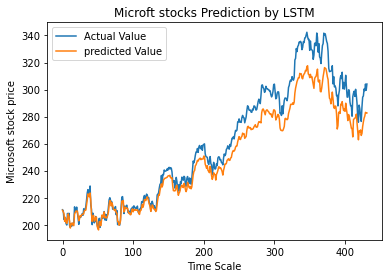

In [54]:
plt.plot(y_test, label="Actual Value")
plt.plot(y_pred, label="predicted Value")
plt.title("Microft stocks Prediction by LSTM")
plt.xlabel("Time Scale")
plt.ylabel("Microsoft stock price")
plt.legend()
plt.show()

In [65]:
# model=Sequential()
# model.add(LSTM(32,input_shape=(1, trainX.shape[1]),activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error',optimizer='adam')

In [66]:
model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1)

Epoch 1/100
1082/1082 [==============================] - 3s 2ms/step - loss: 1236.3430
Epoch 2/100
1082/1082 [==============================] - 2s 2ms/step - loss: 408.5565
Epoch 3/100
1082/1082 [==============================] - 2s 2ms/step - loss: 140.0417
Epoch 4/100
1082/1082 [==============================] - 2s 2ms/step - loss: 76.8654
Epoch 5/100
1082/1082 [==============================] - 2s 2ms/step - loss: 51.7117
Epoch 6/100
1082/1082 [==============================] - 2s 2ms/step - loss: 43.4407
Epoch 7/100
1082/1082 [==============================] - 2s 2ms/step - loss: 38.8669
Epoch 8/100
1082/1082 [==============================] - 2s 2ms/step - loss: 38.9643
Epoch 9/100
1082/1082 [==============================] - 2s 2ms/step - loss: 36.1690
Epoch 10/100
1082/1082 [==============================] - 2s 2ms/step - loss: 35.2860
Epoch 11/100
1082/1082 [==============================] - 2s 2ms/step - loss: 35.4686
Epoch 12/100
1082/1082 [==============================] - 2

In [67]:
# y_pred1= model.predict(X_test)
# print(y_pred1)

[[202.35466]
 [201.09624]
 [199.8937 ]
 [194.06848]
 [196.9743 ]
 [193.37903]
 [192.5508 ]
 [195.07834]
 [199.58102]
 [197.34958]
 [193.6063 ]
 [189.14426]
 [191.26147]
 [192.70255]
 [192.615  ]
 [191.11461]
 [190.89969]
 [198.82701]
 [200.13295]
 [201.76576]
 [201.22607]
 [201.80771]
 [197.94269]
 [194.41281]
 [195.5228 ]
 [198.34839]
 [197.65807]
 [198.69666]
 [199.34586]
 [199.26653]
 [199.46852]
 [201.86284]
 [202.30487]
 [202.44478]
 [205.96024]
 [209.84337]
 [214.89517]
 [213.17976]
 [212.55887]
 [215.34743]
 [209.79257]
 [199.40744]
 [193.84737]
 [197.29376]
 [198.6658 ]
 [194.26682]
 [194.56618]
 [197.25417]
 [197.24551]
 [190.49084]
 [188.96074]
 [187.80121]
 [193.74225]
 [194.08258]
 [190.69724]
 [193.9067 ]
 [198.65555]
 [197.46246]
 [197.00769]
 [201.05835]
 [196.5249 ]
 [197.12411]
 [196.52786]
 [196.70413]
 [198.79388]
 [200.94672]
 [206.53625]
 [209.7236 ]
 [209.38312]
 [205.61238]
 [207.918  ]
 [206.2266 ]
 [203.47014]
 [202.56235]
 [202.1351 ]
 [203.12994]
 [200.40143]

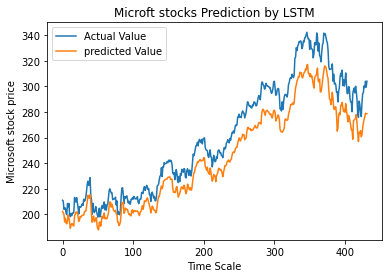

In [68]:
# plt.plot(y_test, label="Actual Value")
# plt.plot(y_pred1, label="predicted Value")
# plt.title("Microft stocks Prediction by LSTM")
# plt.xlabel("Time Scale")
# plt.ylabel("Microsoft stock price")
# plt.legend()
# plt.show()